In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
sys.path.insert(1, "../lib/")
from utils import *
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

/home/prakul/datares/stock_predictor/venv_stock_predictor/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Reading Merged files from Path

In [2]:
stocks = pd.read_csv("../data/Stocks_merged.csv",index_col = 0)
stocks["Date"] = pd.to_datetime(stocks["Date"])
stocks = stocks.set_index("Date",drop=True)
etf = pd.read_csv("../data/ETF_merged.csv",index_col = 0)
etf["Date"] = pd.to_datetime(etf["Date"])
etf = etf.set_index("Date",drop=True)

/home/prakul/datares/stock_predictor/venv_stock_predictor/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
stocks.head()

Open  High   Low  Close  Volume  OpenInt       symbol
Date                                                             
2005-02-25  4.99  5.14  4.90   5.14   32101        0  ntct.us.txt
2005-02-28  5.12  5.19  5.06   5.19   16402        0  ntct.us.txt
2005-03-01  5.18  5.19  5.05   5.07   16500        0  ntct.us.txt
2005-03-02  5.05  5.23  5.05   5.15   26071        0  ntct.us.txt
2005-03-03  5.21  5.21  5.02   5.10    8618        0  ntct.us.txt

In [4]:
etf.head()

Open    High     Low   Close  Volume  OpenInt       symbol
Date                                                                    
2015-03-12  23.019  23.032  22.985  22.985    3025        0  ibdp.us.txt
2015-03-13  22.961  22.968  22.925  22.925    1733        0  ibdp.us.txt
2015-03-16  23.054  23.054  23.054  23.054     429        0  ibdp.us.txt
2015-03-19  23.119  23.119  23.119  23.119     429        0  ibdp.us.txt
2015-03-23  23.119  23.119  23.119  23.119       4        0  ibdp.us.txt

# Selecting top 10 stocks with most data points for plotting

In [5]:
stocks_most_data_points = stocks.groupby("symbol")["Close"].count().sort_values(ascending=False)[:10].index.to_list()

In [6]:
# Selected Stocks
stocks_most_data_points

['ibm.us.txt',
 'ge.us.txt',
 'cat.us.txt',
 'nav.us.txt',
 'mcd.us.txt',
 'dte.us.txt',
 'mmm.us.txt',
 'mrk.us.txt',
 'ip.us.txt',
 'aep.us.txt']

/home/prakul/datares/stock_predictor/venv_stock_predictor/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


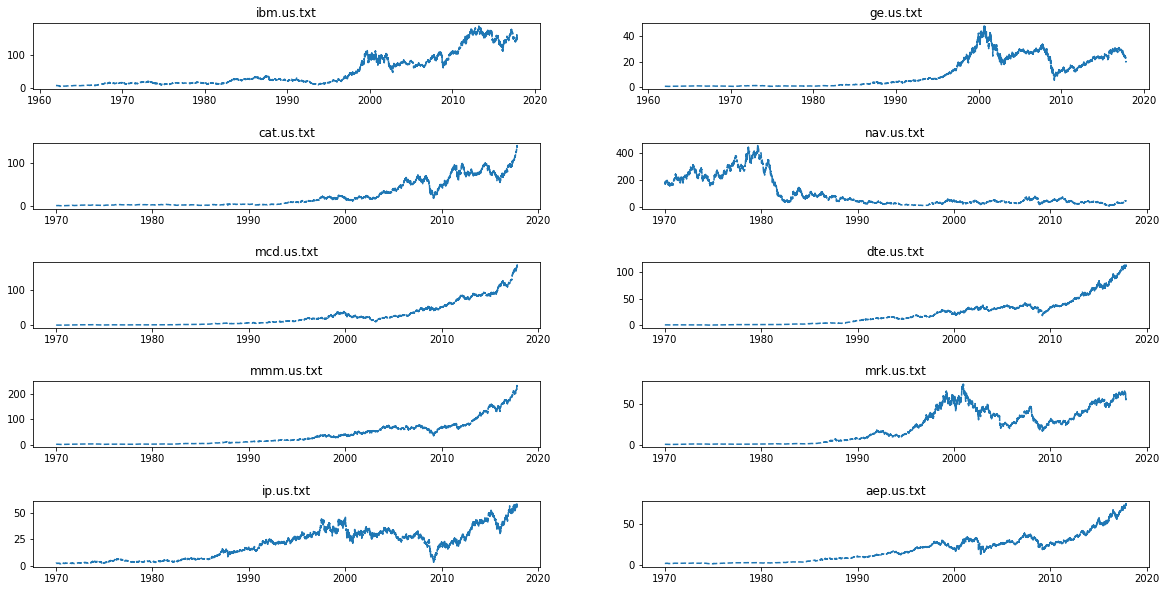

In [7]:
f = plt.figure(figsize=(20,10))

for i in range(len(stocks_most_data_points)):
    stock = stocks.loc[stocks["symbol"] == stocks_most_data_points[i]]
    ax = f.add_subplot(5,2,i+1)
    plt.subplots_adjust(hspace = 0.8)
#     plt.figure(figsize=(6,5))
    ax.plot(stock["Close"],"--",)
    plt.title(stocks_most_data_points[i])

## Checking nulls

In [8]:
stocks.isna().sum()

Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
symbol     0
dtype: int64

No nulls so we can proceed with building pipelines

### To save time we will do following steps with just one stock

In [10]:
stock = stocks.loc[stocks["symbol"] == stocks_most_data_points[5]]
stock.head()

Open    High     Low   Close  Volume  OpenInt      symbol
Date                                                                   
1970-01-02  0.9310  0.9625  0.9310  0.9625    8180        0  dte.us.txt
1970-01-05  0.9625  0.9938  0.9625  0.9860    5115        0  dte.us.txt
1970-01-06  0.9860  1.0018  0.9860  0.9860   14183        0  dte.us.txt
1970-01-07  0.9860  1.0018  0.9860  0.9860   10990        0  dte.us.txt
1970-01-08  0.9860  1.0018  0.9860  1.0018    7799        0  dte.us.txt

In [11]:
data = stock.copy()

# building matrix for data

In [12]:
TIME_STEPS = 60
'''
The number of previous days Neural network will look at data for to predict next value,
Here neural network will look at values of previous 60 days before predicting the next value
'''
BATCH_SIZE = 30
'''
Number of predictions after which to update the weights, 
here neural network will predict values for 30 days before calculating loss and updating weights
'''

'\nNumber of predictions after which to update the weights, \nhere neural network will predict values for 30 days before calculating loss and updating weights\n'

In [13]:
def build_timeseries(mat, y_col_index):
    '''
    y_col_index is the index of column that would act as output column
    total number of time-series samples would be len(mat) - TIME_STEPS
    '''
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1] # dim 1 of matrix is number of features
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    ''' 
    the returned matrix X will have no. of rows = No. of observations
    Columns = No. of Time steps , 
    Layers = No. of features so there will be one layer for each of Open, High, Low, Volume
    '''
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [14]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

## Preprocessing

In [49]:
def preproc_pipeline(data, look_back, batch_size, needs_processing=False):
    
    if needs_processing:
        stocks, etf = fetch_data()
        data = pd.concat([stocks, etf])
        generate_ta(data)
    
    train_cols = list(data.columns)
    train_cols.remove("symbol")
    x = data[train_cols].values
    global min_max_scaler
    min_max_scaler = MinMaxScaler()
    
    X_train, X_test = train_test_split(x, train_size=0.75, test_size=0.25, shuffle=False)
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    
    x_t_train, y_t_train = build_timeseries(X_train, 3)#Close price is 4th column with index of 3
    x_t_train = trim_dataset(x_t_train, BATCH_SIZE)#droping any additional rows from independent variables
    y_t_train = trim_dataset(y_t_train, BATCH_SIZE)#droping any additional rows from dependent variables
    
    x_t_test, y_t_test = build_timeseries(X_test, 3)#Close price is 4th column with index of 3
    x_t_test = trim_dataset(x_t_test, BATCH_SIZE)#droping any additional rows from independent variables
    y_t_test = trim_dataset(y_t_test, BATCH_SIZE)#droping any additional rows from dependent variables
    
    print("Train and Test size", len(x_t_train), len(x_t_test))
    
    return x_t_train,x_t_test,y_t_train,y_t_test

In [50]:
generate_ta(data)
x_t_train,x_t_test,y_t_train,y_t_test = preproc_pipeline(data, look_back=TIME_STEPS, batch_size=BATCH_SIZE, needs_processing=False)

/home/prakul/datares/stock_predictor/venv_stock_predictor/lib/python3.7/site-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/home/prakul/datares/stock_predictor/venv_stock_predictor/lib/python3.7/site-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


length of time-series i/o (8996, 60, 67) (8996,)
length of time-series i/o (2959, 60, 67) (2959,)
Train and Test size 8970 2940


In [51]:
x_t_train.shape

(8970, 60, 67)

In [52]:
y_t_train.shape

(8970,)

In [53]:
x_t_val,x_t_test = np.split(x_t_test, 2)
y_t_val,y_t_test = np.split(y_t_test, 2)

In [54]:
x_t_val.shape

(1470, 60, 67)

# Building Model

In [63]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers

In [72]:
lstm_model = Sequential()
lstm_model.add(LSTM(20,return_sequences=True, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t_train.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(10, dropout=0.0))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(5,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [73]:
history = lstm_model.fit(x_t_train, y_t_train, epochs=5, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_t_val, BATCH_SIZE),
                    trim_dataset(y_t_val, BATCH_SIZE)))

Train on 8970 samples, validate on 1470 samples
Epoch 1/5
 - 7s - loss: 0.0509 - val_loss: 0.0297
Epoch 2/5
 - 7s - loss: 0.0264 - val_loss: 0.0211
Epoch 3/5
 - 6s - loss: 0.0082 - val_loss: 0.0186
Epoch 4/5
 - 7s - loss: 0.0051 - val_loss: 0.0162
Epoch 5/5
 - 7s - loss: 0.0036 - val_loss: 0.0161


In [74]:
from sklearn.metrics import accuracy_score, mean_squared_error

In [75]:
y_pred = lstm_model.predict(trim_dataset(x_t_test, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_t_test = trim_dataset(y_t_test, BATCH_SIZE)
error = mean_squared_error(y_t_test, y_pred)
print("Error is", error, y_pred.shape, y_t_test.shape)

Error is 1.2862309892345019 (1470,) (1470,)


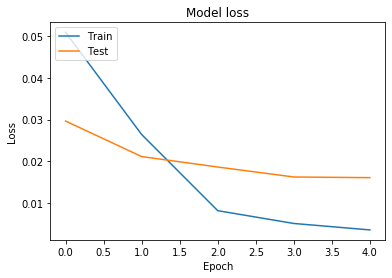

In [76]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [77]:
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_t_test * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[33.869934 33.871967 33.872707 33.874443 33.87461  33.877007 33.87913
 33.879482 33.87941  33.88195  33.88248  33.88159  33.883583 33.882923
 33.88312 ]
[42.163 41.941 42.253 42.197 42.843 43.961 44.502 44.468 44.87  45.157
 44.821 45.132 44.667 44.189 43.968]


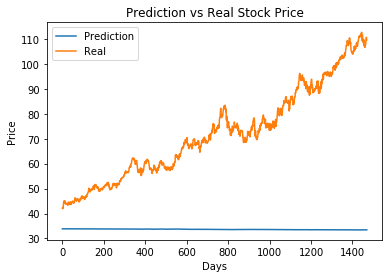

In [78]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')